## plans
1. implement basic validation of each reaction step in isolation
2. incorporate toehold-domain-length tweaking
3. incorporate first passage time measurement and rate analysis so that we can plot as function of toehold domain length and sequence
4. 

ATGTCTGATAATG**GACCCCAAAATCAGCGAAAT**GCACCCCGCATTACGTTTGGTGGACCCT**CAGATTCAACTGGCAGTAACCAGA**ATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCCAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTCTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGA**GGGAGCCTTGAATACACCAAAA**GATCACATTGGCACCCGCAATCCTGCTAA**CAATGCTGCAATCGTGCTACA**ACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCAGTAGGGGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGA**TTACAAACATTGGCCGCAAA**TTGCACAATTTGCCCCCAGCGCTTCAGCG**TTCTTCGGAATGTCGCGC**ATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAA

In [2]:
import sys
sys.path.append('/home/ian/projects/multistrand/multistrand-release-2.1/') #multistrand directory after make installation
from multistrand.objects import *
from multistrand.options import Options
from multistrand.system import *
import numpy as np
import matplotlib.pyplot as plt
import pynupack as nu # renamed the nupack directory from multistrand, slightly modified, used elsewhere

from tqdm import tqdm
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO
from Bio import pairwise2
from Bio.SeqRecord import SeqRecord
from Bio.Align.Applications import MuscleCommandline
from Bio.Alphabet import IUPAC
from Bio.Align import AlignInfo
from Bio.pairwise2 import format_alignment
from Bio import SeqIO

import Levenshtein

In [3]:
do_s1 = True
do_s2 = True
do_s3 = True
do_s4 = True

In [4]:
# CCGCCCAGACACATAATCCCCTGGGAGCCTTGAATACA+CTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAA+CTTTTGGTGTATTCAAGGCTCCCAGGGGATTATGTGTCTGGGCGG 
# .((((((((((((((((((((((((((((((((((...+.........((..(((...))).))..(....((((...)))))...((((((((((......((((((..........))))))+)))))))))))))))))))))))))))))))))))))))))))). 


In [5]:
# More meaningful names for argument values to the energy() function call, below.
Loop_Energy = 0    # requesting no dG_assoc or dG_volume terms to be added.  So only loop energies remain.
Volume_Energy = 1  # requesting dG_volume but not dG_assoc terms to be added.  No clear interpretation for this.
Complex_Energy = 2 # requesting dG_assoc but not dG_volume terms to be added.  This is the NUPACK complex microstate energy, sans symmetry terms.
Tube_Energy = 3    # requesting both dG_assoc and dG_volume terms to be added.  Summed over complexes, this is the system state energy.

In [6]:
#### DEFINE DOMAINS ####
d1 = Domain(name='d1',sequence='CACAGACG') 
d2b = Domain(name='d2b',sequence='CCGCCCAG') 
d2c = Domain(name='d2c',sequence='ACACATAATC') 
d3 = Domain(name='d3',sequence='CCCT')
d4 = Domain(name='d4',sequence='GGGAGCCTTGAATACA')
d5 = Domain(name='d5',sequence='CCAAAA')
d6 = Domain(name='d6',sequence='CCACATACATCATATT')
df4 = Domain(name='df4',sequence='CTAACAAAGACGGCATCATATGGGTTGCAACTGA')
df5 = Domain(name='df5',sequence='GATCACATTGGCACCCGCAATCCTGCTAA')
d_d = Domain(name='d_d',sequence='GTTCTTACT')


domains = [str(d1.sequence), 
             str(d2b.sequence), 
             str(d2c.sequence),
             str(d3.sequence), 
             str(d4.sequence), 
             str(d5.sequence), 
             str(d6.sequence),
             str(d1.C.sequence), 
             str(d2b.C.sequence), 
             str(d2c.C.sequence), 
             str(d3.C.sequence), 
             str(d4.C.sequence), 
             str(d5.C.sequence), 
             str(d6.C.sequence),  ]

In [7]:
#### ASSEMBLE STRANDS ####
OP = d1+d2b +d2c
OP.name = "ouput product"
SP = d6+d3+d4
SP.name = "side product"
SL = d5.C+d4.C+d3.C+d2c.C+d2b.C
SL.name = "substrate lower"
Cat = df4 + d4 + d5 + df5
Cat.name = "catalyst"
Fuel = d2b+d2c+d3+d4
Fuel.name = "fuel"
hairpin_1 = d1 + d2b + d2c + d2b.C + d1.C + d_d.C
hairpin_1.name = "hairpin_1"
hairpin_2 = d2c.C + d2b.C + d1.C + d_d + d1 + d2b
hairpin_2.name = "hairpin_2"
strand_list = [OP,SL,SP,Cat,Fuel,hairpin_1,hairpin_2]
single_strands = [str(SL.sequence), 
             str(OP.sequence), 
             str(SP.sequence), 
             str(Cat.sequence), 
             str(Fuel.sequence),
                 str(hairpin_1.sequence),
                 str(hairpin_2.sequence),]

In [8]:

for seq in strand_list:
    print(str(seq.name)+","+ str(seq.sequence))
    for d in seq.domain_list:
        print("\t" + str(d.name) + " " + str(d.sequence))
    

ouput product,CACAGACGCCGCCCAGACACATAATC
	d1 CACAGACG
	d2b CCGCCCAG
	d2c ACACATAATC
substrate lower,TTTTGGTGTATTCAAGGCTCCCAGGGGATTATGTGTCTGGGCGG
	d5* TTTTGG
	d4* TGTATTCAAGGCTCCC
	d3* AGGG
	d2c* GATTATGTGT
	d2b* CTGGGCGG
side product,CCACATACATCATATTCCCTGGGAGCCTTGAATACA
	d6 CCACATACATCATATT
	d3 CCCT
	d4 GGGAGCCTTGAATACA
catalyst,CTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAA
	df4 CTAACAAAGACGGCATCATATGGGTTGCAACTGA
	d4 GGGAGCCTTGAATACA
	d5 CCAAAA
	df5 GATCACATTGGCACCCGCAATCCTGCTAA
fuel,CCGCCCAGACACATAATCCCCTGGGAGCCTTGAATACA
	d2b CCGCCCAG
	d2c ACACATAATC
	d3 CCCT
	d4 GGGAGCCTTGAATACA
hairpin_1,CACAGACGCCGCCCAGACACATAATCCTGGGCGGCGTCTGTGAGTAAGAAC
	d1 CACAGACG
	d2b CCGCCCAG
	d2c ACACATAATC
	d2b* CTGGGCGG
	d1* CGTCTGTG
	d_d* AGTAAGAAC
hairpin_2,GATTATGTGTCTGGGCGGCGTCTGTGGTTCTTACTCACAGACGCCGCCCAG
	d2c* GATTATGTGT
	d2b* CTGGGCGG
	d1* CGTCTGTG
	d_d GTTCTTACT
	d1 CACAGACG
	d2b CCGCCCAG


In [8]:
#### CONSTRUCT COMPLEXES / REACTION STEPS TO INVESTIGATE ####
substrate_complex = Complex(strands=[OP, SP, SL],
                              structure=".((+.((+.))))")
catalyst_substrate_complex = Complex(strands=[OP, SP, Cat, SL],
                              structure=".((+.((+..(.+)))))")
fuel_toe_intermediate = Complex(strands=[OP, Fuel, Cat, SL],
                              structure=".((+..(.+.((.+)))))")
i_hp2_plex_init = Complex( strands=[hairpin_2,OP],structure="(((.))+..)")
hcr_triplex = Complex(strands=[hairpin_2,hairpin_1,OP],structure="((((..+((.)))+)))")

In [9]:
import pynupack as nu # renamed the nupack directory from multistrand, slightly modified, used elsewhere

def get_hairpin_struct(sequence, material = 'dna',ordering = None, dangles = 'some',
    T = 25,multi = False ,pseudo = False,sodium = 1.0,magnesium = 0.0 ,degenerate = False):
    #### compute annealed structures of hairpin strands ####
    args, cmd_input = \
    nu.setup_nupack_input(exec_name = 'mfe', sequences = [sequence], ordering = ordering,
                       material = material, sodium = sodium, magnesium = magnesium,
                       dangles = dangles, T = T, multi = multi, pseudo = pseudo)
    output = nu.call_with_file(args, cmd_input, '.mfe')
    cleaned_output = list(enumerate(output))[0][1]
    for line in cleaned_output:
        if '.' in line[0] or "(" in line[0]:
            return line.replace("\n", "")   
        
def get_duplex_struct(sequences, material = 'dna',ordering = None, dangles = 'some',
    T = 25,multi = False ,pseudo = False,sodium = 1.0,magnesium = 0.0 ,degenerate = False, full_output = False):
    #### compute annealed structures of hairpin strands ####
    args, cmd_input = \
    nu.setup_nupack_input(exec_name = 'mfe', sequences = sequences, ordering = ordering,
                       material = material, sodium = sodium, magnesium = magnesium,
                       dangles = dangles, T = T, multi = multi, pseudo = pseudo)
    output = nu.call_with_file(args, cmd_input, '.mfe')
    cleaned_output = list(enumerate(output))[0][1]
    duplex_energy = float(cleaned_output[14].replace("\n", ""))
    try:
        duplex_structure = cleaned_output[15].replace("\n", "") 
    except: pass
    return duplex_structure, cleaned_output, duplex_energy

def get_duplex_energy(sequences, material = 'dna',ordering = None, dangles = 'some',
    T = 25,multi = False ,pseudo = False,sodium = 1.0,magnesium = 0.0 ,degenerate = False, full_output = False):
    #### compute annealed structures of hairpin strands ####
    args, cmd_input = \
    nu.setup_nupack_input(exec_name = 'mfe', sequences = sequences, ordering = ordering,
                       material = material, sodium = sodium, magnesium = magnesium,
                       dangles = dangles, T = T, multi = multi, pseudo = pseudo)
    output = nu.call_with_file(args, cmd_input, '.mfe')
    cleaned_output = list(enumerate(output))[0][1]
    try: 
        duplex_energy = float(cleaned_output[14].replace("\n", ""))
        if full_output == True:
            print(duplex_energy, cleaned_output[15].replace("\n", ""), sequences)
    except:
        duplex_energy = 0
    return duplex_energy
# generalized from "hairpin trajectories tutorial" version to allow multistrand complexes and multiple complexes in a tube
def print_trajectory(o):
    seqstring=''
    energies = np.zeros((len(o.full_trajectory)))
    for i in range(len(o.full_trajectory)): # go through each output microstate of the trajectory
        time = o.full_trajectory_times[i]   # time at which this microstate is entered
        states = o.full_trajectory[i]       # this is a list of the complexes present in this tube microstate
        newseqs = []
        for state in states: newseqs += [ state[3] ]   # extract the strand sequences in each complex (joined by "+" for multistranded complexes)
        newseqstring = ' '.join(newseqs)    # make a space-separated string of complexes, to represent the whole tube system sequence
        if not newseqstring == seqstring : 
            print newseqstring
            seqstring=newseqstring          # because strand order can change upon association of dissociation, print it when it changes
        structs = []
        for state in states: structs += [ state[4] ]   # similarly extract the secondary structures for each complex
        tubestruct = ' '.join(structs)      # give the dot-paren secondary structure for the whole test tube
        dG=0
        for state in states: dG += state[5]
        if i%250 ==0:
            print '%s t=%11.9f seconds, dG=%6.2f kcal/mol' % (tubestruct,time, dG)
        energies[i] = dG

        # Needlessly verify that the reported trajectory energies are the Tube_Energy values
        dGv=0
        for state in states:
            cs=state[3].split('+')
            st=state[4]
            dGv += energy( [Complex( strands=[Strand(sequence=s) for s in cs], structure=st)], o, Tube_Energy)[0]  
        if not dGv == dG: print "Energy Mismatch"
    return energies

def print_trajectory2(o):
    seqstring=''
    energies = np.zeros((len(o.full_trajectory)))
    for i in range(len(o.full_trajectory)): # go through each output microstate of the trajectory
        time = o.full_trajectory_times[i]   # time at which this microstate is entered
        states = o.full_trajectory[i]       # this is a list of the complexes present in this tube microstate
        newseqs = []
        for state in states: newseqs += [ state[3] ]   # extract the strand sequences in each complex (joined by "+" for multistranded complexes)
        newseqstring = ' '.join(newseqs)    # make a space-separated string of complexes, to represent the whole tube system sequence
        if not newseqstring == seqstring : 
            print newseqstring
            seqstring=newseqstring          # because strand order can change upon association of dissociation, print it when it changes
        structs = []
        for state in states: structs += [ state[4] ]   # similarly extract the secondary structures for each complex
        tubestruct = ' '.join(structs)      # give the dot-paren secondary structure for the whole test tube
        dG=0
        for state in states: dG += state[5]
        if i%250 ==0:
            print '%s t=%11.9f seconds, dG=%6.2f kcal/mol' % (tubestruct,time, dG)
        energies[i] = dG
    return energies

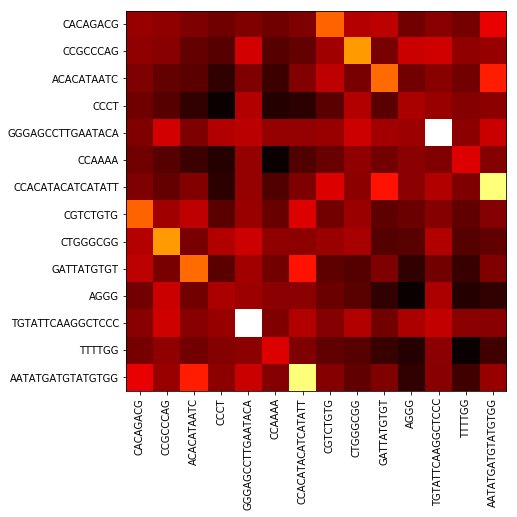

In [10]:

no_domains = len(domains)
e_mat_domains = np.zeros((no_domains,no_domains))
for i in range(0,no_domains):
    for j in range(0, no_domains):
        e_mat_domains[i,j] = get_duplex_energy([domains[i], domains[j]])
 
fig = plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 10})

ax1 = fig.add_subplot(111)
ax1.set_yticks(np.arange(0,no_domains))

ax1.imshow(e_mat_domains,cmap="hot_r") 
ax1.set_yticklabels([x for x in domains],rotation=0)
ax1.set_xticks(np.arange(0,no_domains))
ax1.set_xticklabels([x for x in domains],rotation=90)

plt.show()
plt.close()


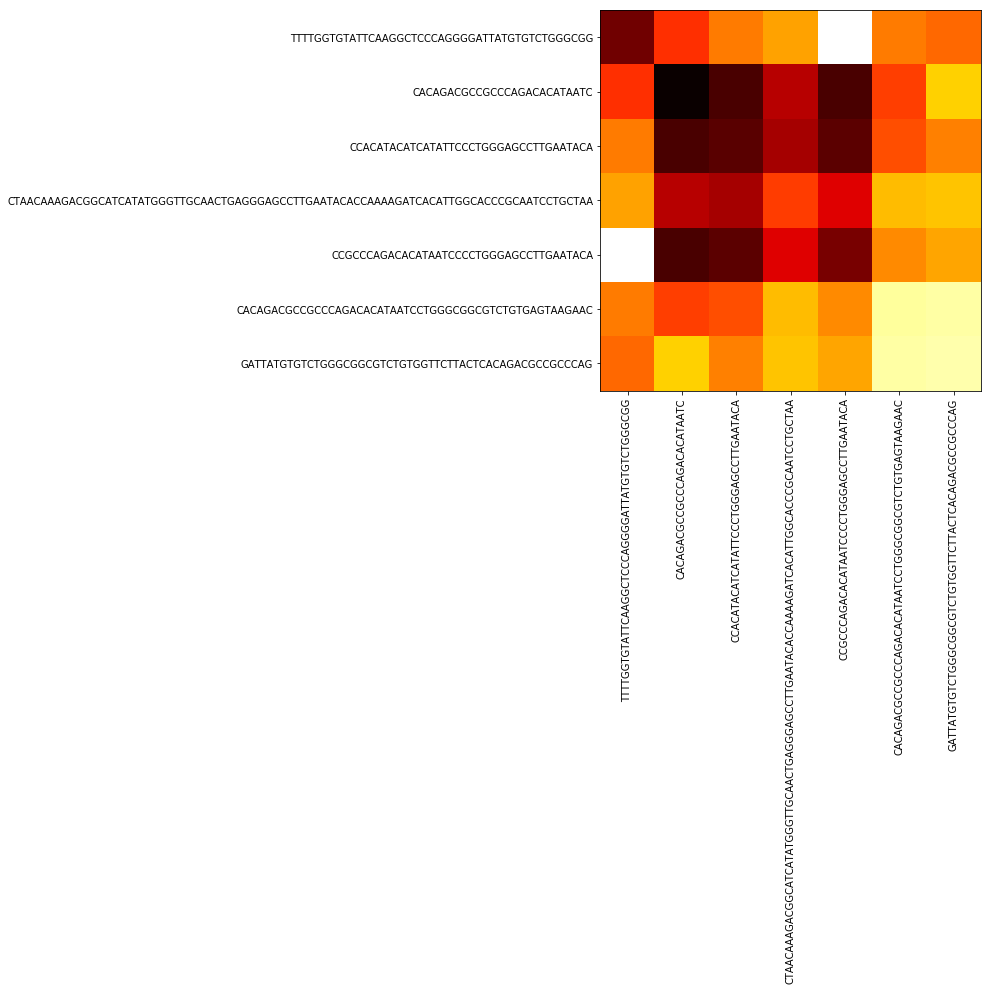

In [11]:
no_single_strands = len(single_strands)
e_mat_single_strands = np.zeros((no_single_strands,no_single_strands))
for i in range(0,no_single_strands):
    for j in range(0, no_single_strands):
        e_mat_single_strands[i,j] = get_duplex_energy([single_strands[i], single_strands[j]])

fig = plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 10})

ax1 = fig.add_subplot(111)
ax1.set_yticks(np.arange(0,len(single_strands)))

ax1.imshow(e_mat_single_strands,cmap="hot_r")  
ax1.set_yticklabels([x for x in single_strands],rotation=0)
ax1.set_xticks(np.arange(0,len(single_strands)))
ax1.set_xticklabels([x for x in single_strands],rotation=90)

plt.show()
plt.close()


Warning! rate_scaling is set, enabling support for legacy code. Now setting rate defaults for Kawasaki 25 C
CACAGACGCCGCCCAGACACATAATC+CCACATACATCATATTCCCTGGGAGCCTTGAATACA+CTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAA+TTTTGGTGTATTCAAGGCTCCCAGGGGATTATGTGTCTGGGCGG
........((((((((((((((((((+................((((((((((((((((((((+..................................................((((((.............................+)))))))))))))))))))))))))))))))))))))))))))) t=0.000000000 seconds, dG=-40.94 kcal/mol
........((((((((((((((((..+....(((.....))).((((((((((((........+............(((..........))).....(((...)))((((((((((((((.........((...))(((....)))...+))))))))))))))))))))))))))..)))))))))))))))) t=0.000016298 seconds, dG=-42.77 kcal/mol
........((((((((((((((((((+....(((.....))).(((((((((((((((.....+....(((....(((.(((..((.....))..)))....))))))...(((((((((..........(....)(((....)))...+)))))))))..))))))))))))))))))))))))))))))))) t=0.000032865 seconds, dG=-4

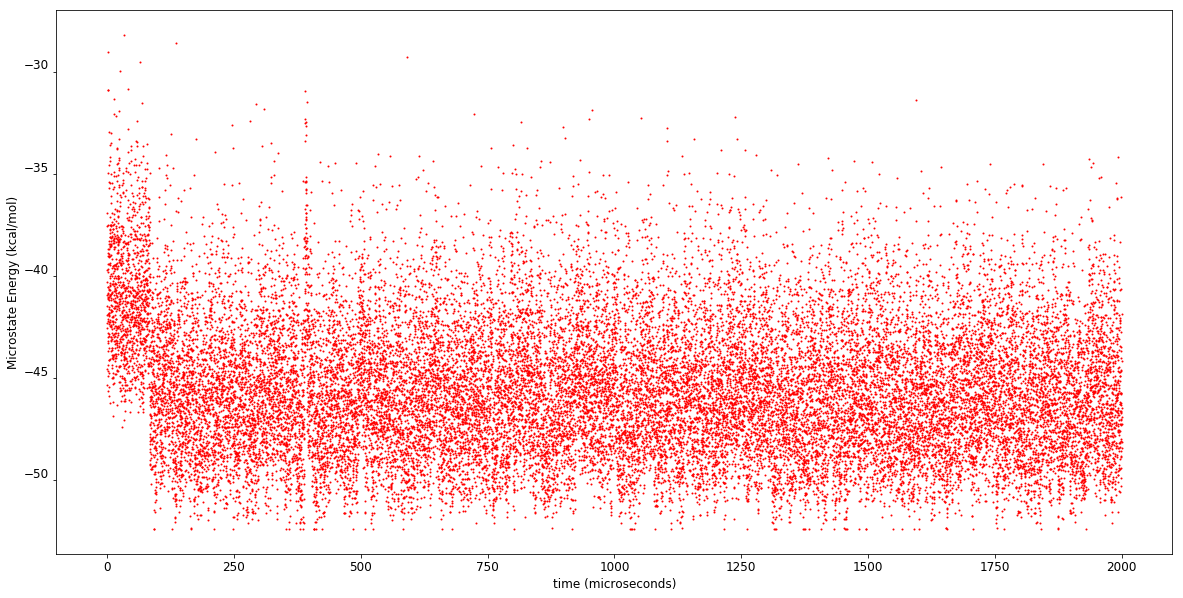

In [12]:
if do_s1:
    #### parameters ####
    o1 = Options()
    o1.simulation_mode = 0x0080 # trajectory mode
    o1.num_simulations = 1
    o1.simulation_time = 0.002 # 200 microseconds, about 250 steps
    o1.temperature = 25.0
    o1.dangles = 1
    o1.output_interval = 100   # record every 100 steps (so we'll get around 100 record entries)
    o1.start_state = [catalyst_substrate_complex]
    o1.rate_scaling="Calibrated"
    o1.join_concentration=1e-6  # 1 uM 
    o1.verbosity=0 
    
    #### simulate ####
    s1 = SimSystem(o1)
    s1.start()
    
    #### printing ####
    energies = print_trajectory2(o1)
    
    #### plotting ####
    times_hcr = np.array(o1.full_trajectory_times)*1000000
    energies_hcr = np.asarray([x[0] for x in o1.full_trajectory]).T[6].astype(float)
    plt.figure(figsize = (20,10))
    plt.scatter(times_hcr,energies, c="r",alpha=1,s=1)
    # plt.title("Energy landscape for intiation \n (%d nM, %6.2fK)" % (o.join_concentration * 1e9, o.temperature) )
    plt.xlabel("time (microseconds)",fontsize='larger')
    plt.ylabel("Microstate Energy (kcal/mol)",fontsize='larger')
    plt.yticks(fontsize='larger',va='bottom')
    plt.xticks(fontsize='larger')
    # plt.ylim(-100,0)

    # plt.ylim(-45,-20)
    plt.show()
    plt.close()
#     print
# print "Sequence Design 1 (shown every 100 steps):"

Warning! rate_scaling is set, enabling support for legacy code. Now setting rate defaults for Kawasaki 25 C
CACAGACGCCGCCCAGACACATAATC+CCGCCCAGACACATAATCCCCTGGGAGCCTTGAATACA+CTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAA+TTTTGGTGTATTCAAGGCTCCCAGGGGATTATGTGTCTGGGCGG
........((((((((((((((((((+..................((((................+..................................((((((((((((((((((((((.............................+)))))))))))))))))))))))))))))))))))))))))))) t=0.000000000 seconds, dG=-40.96 kcal/mol
........(((((.............+.......(((((((((((((((((((((((((......+((.....))...(((.(.....)..))).....(((...)))..((((((((((((...((...))......(((....)))...+)))))))))))))))))))))))))))))))))))))..))))) t=0.000016025 seconds, dG=-44.48 kcal/mol
CCGCCCAGACACATAATCCCCTGGGAGCCTTGAATACA+CTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAA+TTTTGGTGTATTCAAGGCTCCCAGGGGATTATGTGTCTGGGCGG CACAGACGCCGCCCAGACACATAATC
.((((((.((((((((((((

..(.(........).).......... ....(...)...(((......(((((((......(((.(((.((.((..........))..))..))).)))))))))))))... .......(((((((((((((((((((((((((((((((((((((+))))))))))))))))))))))))))))))))))))). t=0.007581454 seconds, dG=-61.11 kcal/mol
.......................... ............(((.(.....)..)))...((.(((.(((.((.((..........))..))..))).))).)).......... .......((((((((((((((((((((((((((((((((((((.+.)))))))))))))))))))))))))))))))))))). t=0.007599400 seconds, dG=-61.06 kcal/mol
..........(........)...... ((.....))...(((......(((((((......(((.(((.(...................)..))).)))))))))))))... ......((((((((((((((((((((((((((((((((((((((+)))))))))))))))))))))))))))))))))))))) t=0.007616906 seconds, dG=-60.53 kcal/mol
..........(........)...... ............(((......(((((((......(((.(((.((.((..........))..))..))).)))))))))))))... .......(((((((((((((((((((((((((((((((((((((+))))))))))))))))))))))))))))))))))))). t=0.007636342 seconds, dG=-62.72 kcal/mol
.......................... ........((.....))

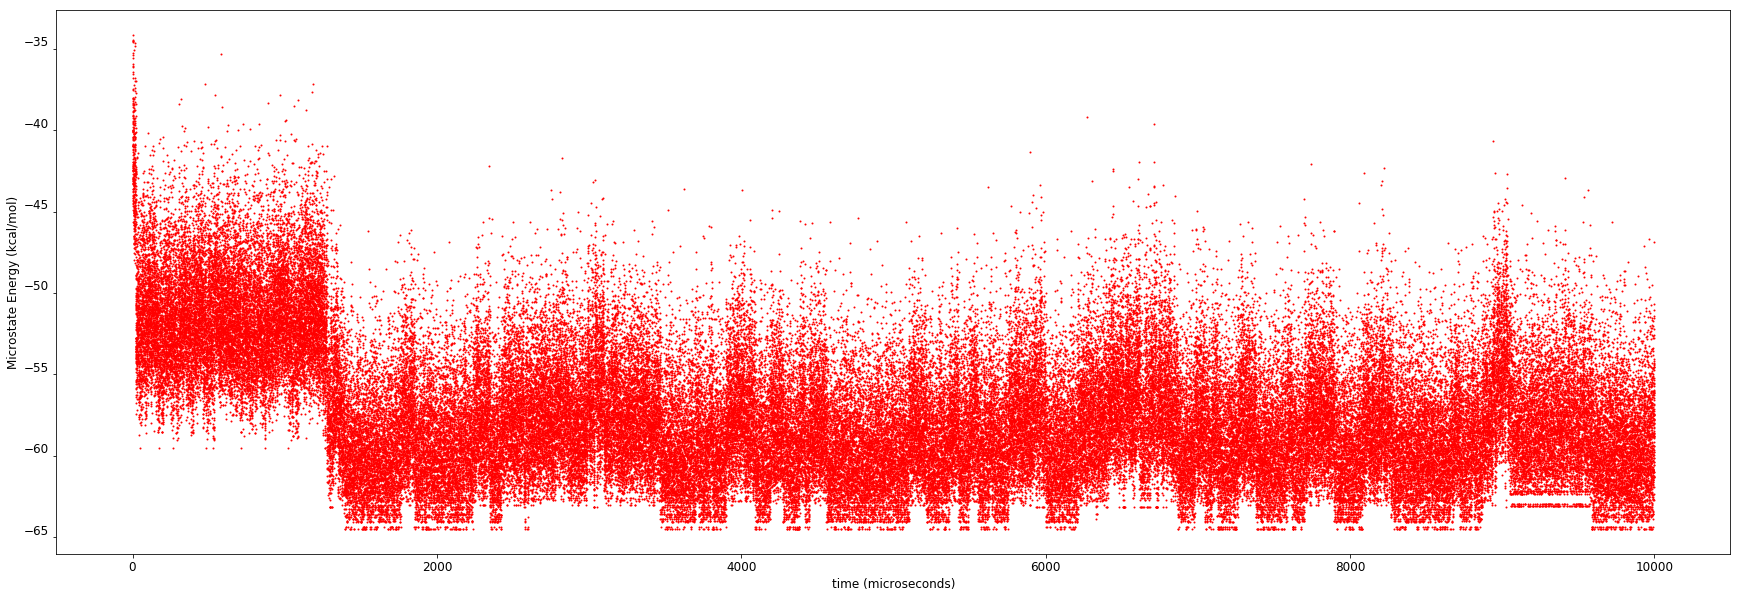

In [13]:
if do_s2:
    o2 = Options()
    o2.simulation_mode = 0x0080 # trajectory mode
    o2.num_simulations = 1
    o2.simulation_time = 0.01 # 200 microseconds, about 250 steps
    o2.temperature = 25.0
    o2.dangles = 1
    o2.output_interval = 100   # record every 100 steps (so we'll get around 100 record entries)
    o2.start_state = [fuel_toe_intermediate]
    o2.rate_scaling="Calibrated"
    o2.join_concentration=1e-6  # 1 uM 
    o2.verbosity=0 
    
    s2 = SimSystem(o2)
    s2.start()
    
    energies2 = print_trajectory2(o2)
    
    times_hcr2 = np.array(o2.full_trajectory_times)*1000000
    energies_hcr2 = np.asarray([x[0] for x in o2.full_trajectory]).T[6].astype(float)
    plt.figure(figsize = (30,10))
    plt.scatter(times_hcr2,energies2, c="r",alpha=1,s=1)
    # plt.title("Energy landscape for intiation \n (%d nM, %6.2fK)" % (o.join_concentration * 1e9, o.temperature) )
    plt.xlabel("time (microseconds)",fontsize='larger')
    plt.ylabel("Microstate Energy (kcal/mol)",fontsize='larger')
    plt.yticks(fontsize='larger',va='bottom')
    plt.xticks(fontsize='larger')
    # plt.ylim(-80,-20)
    plt.show()
    plt.close()    

Warning! rate_scaling is set, enabling support for legacy code. Now setting rate defaults for Kawasaki 25 C
GATTATGTGTCTGGGCGGCGTCTGTGGTTCTTACTCACAGACGCCGCCCAG+CACAGACGCCGCCCAGACACATAATC
((((((((((((((((((((((((((.........))))))))))))))))+................)))))))))) t=0.000000000 seconds, dG=-29.50 kcal/mol
((((((((((((((((((((((((((.........))))))))))))))).+....(..(...).).))))))))))) t=0.000045208 seconds, dG=-26.00 kcal/mol
((((((((((((((((((((((((((.........................+)))))))))))))))))))))))))) t=0.000089296 seconds, dG=-34.36 kcal/mol
..(((((((((((((((((((((((........((...))....(.....)+.))))))))))))))))))))))).. t=0.000133389 seconds, dG=-29.46 kcal/mol
((((((((((((((((((((((((((.......((...))...........+)))))))))))))))))))))))))) t=0.000178772 seconds, dG=-34.52 kcal/mol


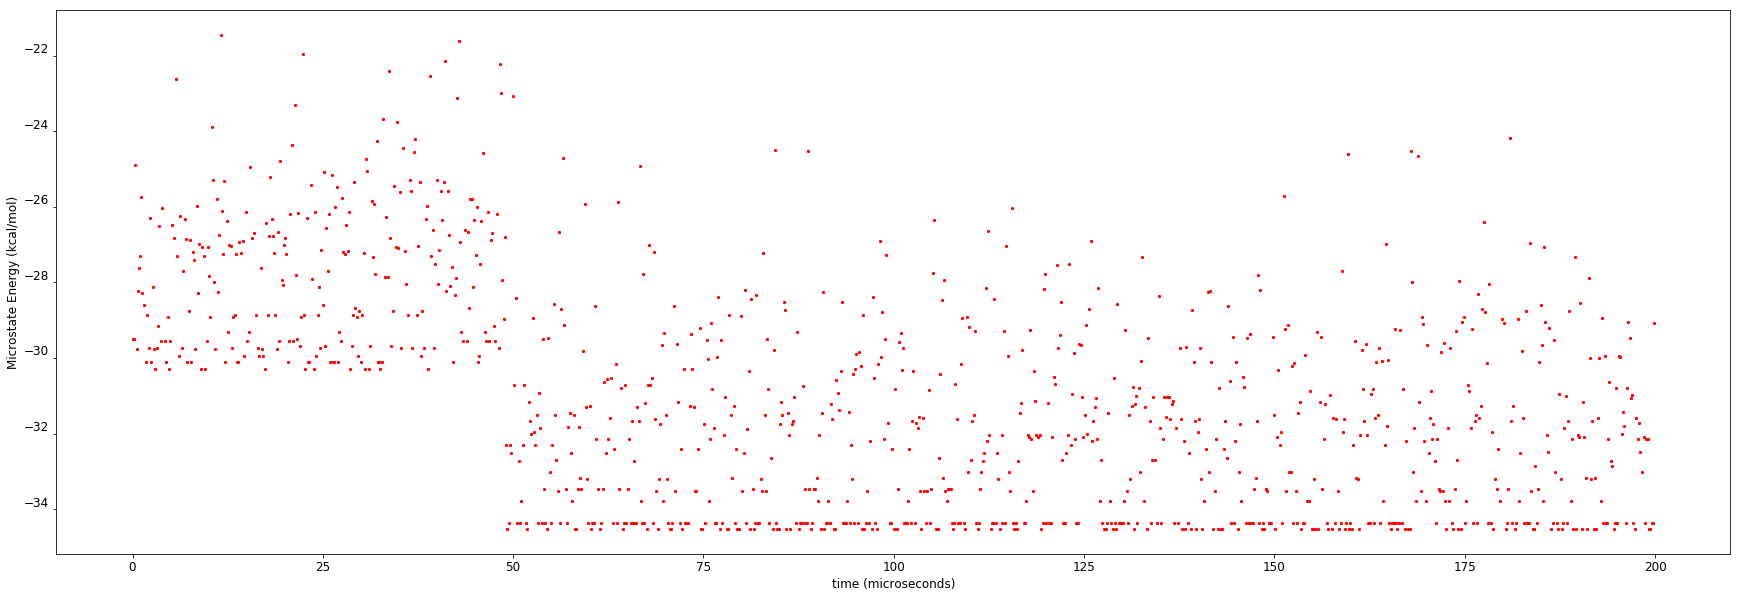

In [14]:
if do_s3:
    o3 = Options()
    o3.simulation_mode = 0x0080 # trajectory mode
    o3.num_simulations = 1
    o3.simulation_time = 0.0002 # 200 microseconds, about 250 steps
    o3.temperature = 25.0
    o3.dangles = 1
    o3.output_interval = 100   # record every 100 steps (so we'll get around 100 record entries)
    o3.start_state = [i_hp2_plex_init]
    o3.rate_scaling="Calibrated"
    o3.join_concentration=1e-6  # 1 uM 
    o3.verbosity=0 
    
    s3 = SimSystem(o3)
    s3.start()
    
    energies3 = print_trajectory2(o3)
    
    times_hcr3 = np.array(o3.full_trajectory_times)*1000000
    energies_hcr3 = np.asarray([x[0] for x in o3.full_trajectory]).T[6].astype(float)
    plt.figure(figsize = (30,10))
    plt.scatter(times_hcr3,energies3, c="r",alpha=1,s=5)
    # plt.title("Energy landscape for intiation \n (%d nM, %6.2fK)" % (o.join_concentration * 1e9, o.temperature) )
    plt.xlabel("time (microseconds)",fontsize='larger')
    plt.ylabel("Microstate Energy (kcal/mol)",fontsize='larger')
    plt.yticks(fontsize='larger',va='bottom')
    plt.xticks(fontsize='larger')
    # plt.ylim(-80,-20)
    plt.show()
    plt.close()

Warning! rate_scaling is set, enabling support for legacy code. Now setting rate defaults for Kawasaki 25 C
GATTATGTGTCTGGGCGGCGTCTGTGGTTCTTACTCACAGACGCCGCCCAG+CACAGACGCCGCCCAGACACATAATCCTGGGCGGCGTCTGTGAGTAAGAAC+CACAGACGCCGCCCAGACACATAATC
(((((((((((((((((((((((((((((((((((................+((((((((((((((((..........)))))))))))))))))))))))))+)))))))))))))))))))))))))) t=0.000000000 seconds, dG=-61.21 kcal/mol
(((((((((((((((((((((((((.(((((((((((((.(((((((((((+..........................))))))))))).)))))))))))))+.))))))))))))))))))))))))) t=0.000035076 seconds, dG=-62.03 kcal/mol
(((((((((((((((((((((((((((((((((((((((((((((((((((+..........................)))))))))))))))))))))))))+)))))))))))))))))))))))))) t=0.000068077 seconds, dG=-66.87 kcal/mol
((((((((((((((((((((((((..(((((((((((((((((((((((((+..........................)))))))))))))))))))))))))+..)))))))))))))))))))))))) t=0.000101959 seconds, dG=-65.80 kcal/mol
.((((((((((((((((((((((((((((((((((((((((((((((((((+.......(.........

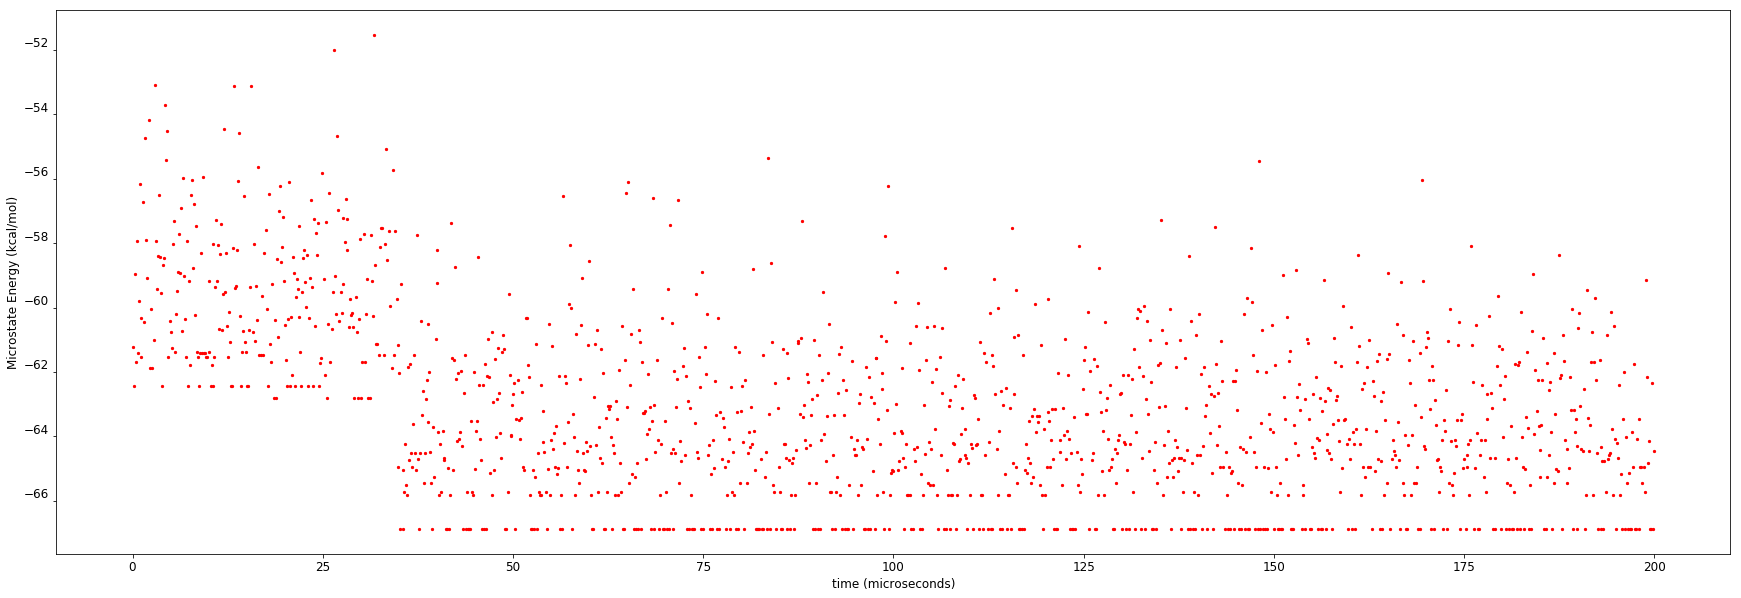

In [15]:
if do_s4:
    o4 = Options()
    o4.simulation_mode = 0x0080 # trajectory mode
    o4.num_simulations = 1
    o4.simulation_time = 0.0002 # 200 microseconds, about 250 steps
    o4.temperature = 25.0
    o4.dangles = 1
    o4.output_interval = 100   # record every 100 steps (so we'll get around 100 record entries)
    o4.start_state = [hcr_triplex]
    o4.rate_scaling="Calibrated"
    o4.join_concentration=1e-6  # 1 uM 
    o4.verbosity=0 
    
    s4 = SimSystem(o4)
    s4.start()
    
    energies4 = print_trajectory2(o4)
    
    times_hcr4 = np.array(o4.full_trajectory_times)*1000000
    energies_hcr4 = np.asarray([x[0] for x in o4.full_trajectory]).T[6].astype(float)
    plt.figure(figsize = (30,10))
    plt.scatter(times_hcr4,energies4, c="r",alpha=1,s=5)
    # plt.title("Energy landscape for intiation \n (%d nM, %6.2fK)" % (o.join_concentration * 1e9, o.temperature) )
    plt.xlabel("time (microseconds)",fontsize='larger')
    plt.ylabel("Microstate Energy (kcal/mol)",fontsize='larger')
    plt.yticks(fontsize='larger',va='bottom')
    plt.xticks(fontsize='larger')
    # plt.ylim(-80,-20)
    plt.show()
    plt.close()